<a href="https://colab.research.google.com/github/tkm2261/mnist_adversarial_attack/blob/master/mnist_adversarial_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
!pip install keras tqdm -U

from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Activation, MaxPooling2D, Conv2D, Conv1D, Lambda, Flatten
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.losses import categorical_crossentropy
import tensorflow as tf

DTYPE = np.float32

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.2.4)
Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.28.1)


Using TensorFlow backend.


In [2]:
tf.test.gpu_device_name(), keras.__version__

('/device:GPU:0', '2.2.4')

# Load data

In [0]:
(x_all, y_all), (x_test, y_test) = mnist.load_data()

idx_train, idx_valid = next(StratifiedKFold(n_splits=10, shuffle=True, random_state=0).split(x_all, y_all))

x_train = (x_all[idx_train] / 255).astype(DTYPE)
y_train = y_all[idx_train]
x_valid = (x_all[idx_valid] / 255).astype(DTYPE)
y_valid = y_all[idx_valid]
x_test = (x_test / 255).astype(DTYPE)
y_all_onehot = np.eye(10)[y_all].astype(DTYPE)
y_train_onehot = np.eye(10)[y_train].astype(DTYPE)
y_valid_onehot = np.eye(10)[y_valid].astype(DTYPE)
y_test_onehot = np.eye(10)[y_test].astype(DTYPE)

# Check data

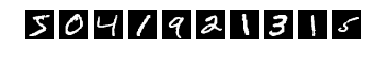

label: [5 0 4 1 9 2 1 3 1 5]


In [4]:
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow((x_train[i] * 255).astype(int), cmap='Greys_r')
    plt.axis('off')
plt.show()
print('label: %s' % (y_train[0:10],))

# Define network

In [0]:
def create_network(input_shape=(28, 28), learning_rate=1.0e-4):
    """create_network
    
    This network is the same as this paper: https://nicholas.carlini.com/papers/2017_sp_nnrobustattacks.pdf
    """
    input_data = Input(shape=input_shape, dtype=DTYPE, name='input')
    hidden = Lambda(K.expand_dims)(input_data) # create channel dim
    hidden = Conv2D(32, (3, 3), padding='same')(hidden)
    hidden = Activation('relu')(hidden)
    hidden = Conv2D(32, (3, 3), padding='same')(hidden)
    hidden = Activation('relu')(hidden)
    hidden = MaxPooling2D(pool_size=(2, 2))(hidden)
    hidden = Conv2D(64, (3, 3), padding='same')(hidden)
    hidden = Activation('relu')(hidden)
    hidden = Conv2D(64, (3, 3), padding='same')(hidden)
    hidden = Activation('relu')(hidden)
    hidden = MaxPooling2D(pool_size=(2, 2))(hidden)
    
    hidden = Flatten()(hidden)
    hidden = Dense(200)(hidden)
    hidden = Dense(200)(hidden)
    hidden = Dense(10, name='before_softmax')(hidden)
    output = Activation('softmax')(hidden)
    
    model = Model(input_data, output)
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=learning_rate),
                  metrics=['accuracy'])
    return model
    

In [6]:
model = create_network()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28)            0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
__________

# Train and Evaluate model

In [0]:
metric = 'val_loss'
mode = 'min'
callbacks = [EarlyStopping(monitor=metric,
                           patience=8,
                           verbose=1,
                           min_delta=1e-4,
                           mode=mode),
             ReduceLROnPlateau(monitor=metric,
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               min_delta=1e-4,
                               mode=mode),
             ModelCheckpoint(monitor=metric,
                             filepath='best_weights.hdf5',
                             save_best_only=False,
                             save_weights_only=False,
                             mode='min')]

#model.fit(x_train, y_train_onehot, epochs=10000, batch_size=128, callbacks=callbacks, 
#          validation_data=(x_valid, y_valid_onehot))

In [8]:
model.load_weights('best_weights.hdf5')
preds = model.predict(x_test, batch_size=512)
pred_labels = preds.argmax(axis=1)
print('Test Accuracy:', (pred_labels == y_test).mean())

Test Accuracy: 0.9908


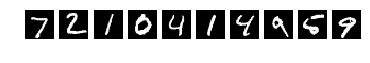

pred label: [7 2 1 0 4 1 4 9 5 9]
true label: [7 2 1 0 4 1 4 9 5 9]


In [9]:
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow((x_test[i] * 255).astype(int), cmap='Greys_r')
    plt.axis('off')
plt.show()
print('pred label: %s' % (pred_labels[0:10],))
print('true label: %s' % (y_test[0:10],))

# Create Adversarial examples

## Define objectives

In [0]:
def adv_obj1(y_target, y_pred):
  return - tf.log(tf.reduce_max(tf.multiply(y_target, y_pred), axis=None)) + 1
  
def adv_obj2(y_target, y_pred):
  target_pred = tf.reduce_max(tf.multiply(y_target, y_pred), axis=None)
  second_pred = tf.reduce_max(tf.multiply(- y_target, y_pred), axis=None)
  diff = tf.clip_by_value(second_pred - target_pred, 0, 1)
  return diff
  
def adv_obj3(y_target, y_pred):
  target_pred = tf.reduce_max(tf.multiply(y_target, y_pred), axis=None)
  second_pred = tf.reduce_max(tf.multiply(- y_target, y_pred), axis=None)
  diff = second_pred - target_pred
  return tf.math.softplus(diff) - np.log(2)

def adv_obj4(y_target, y_pred):
  target_pred = tf.reduce_max(tf.multiply(y_target, y_pred), axis=None)
  diff = tf.clip_by_value(0.5 - target_pred, 0, 1)
  return tf.reduce_mean(diff)

def adv_obj5(y_target, y_pred):
  target_pred = tf.reduce_max(tf.multiply(y_target, y_pred), axis=None)
  return - tf.math.log(2 * target_pred - 2)

def adv_obj6(y_target, y_pred_before_softmax):
  return adv_obj2(y_target, y_pred_before_softmax)
  
def adv_obj7(y_target, y_pred_before_softmax):
  return adv_obj3(y_target, y_pred_before_softmax)

def l2_norm(delta):
  return tf.reduce_sum(tf.square(delta))

## Define "create_adversal_example" method

In [0]:
class CWAdversarial:
  def __init__(self, sess, model, max_iter=10000, norm_p=2, tol=1.0e-15, shape=(1, 28, 28), lr=0.1, c=10):
    self.sess = sess
    self.model = model
    self.max_iter = max_iter
    self.norm_p = norm_p
    self.tol = tol
    self.shape = shape
    self.lr = lr
    self.c = c
    
    self.buf_data = tf.placeholder(DTYPE, shape=shape)
    self.buf_target_label = tf.placeholder(DTYPE, shape=(1, 10))

    self.delta = tf.Variable(np.zeros(shape, dtype=DTYPE))
    self.data = tf.Variable(np.zeros(shape, dtype=DTYPE))
    self.target_label  = tf.Variable(np.zeros(shape=(1, 10), dtype=DTYPE))

    self.pred = model(tf.clip_by_value(self.delta + self.data, 0, 1))

    self.obj = l2_norm(self.delta) + self.c * adv_obj1(self.target_label, self.pred)
    self.optimizer = tf.train.AdamOptimizer(self.lr)
    self.train_step = self.optimizer.minimize(self.obj, var_list=[self.delta])
    
    self.new_vars = [v for v in tf.global_variables() if v.name.split(':')[0]
                     in set(sess.run(tf.report_uninitialized_variables()))]
    
  def create_adversal_example(self, _img, _target_label):

      _perturbation = np.zeros(self.shape, dtype=DTYPE)

      _prev_objval = None
      _objval = None

      self.sess.run(tf.variables_initializer(var_list=[self.data, self.delta] + self.optimizer.variables()))
      self.sess.run(tf.variables_initializer(self.new_vars))
      
      self.sess.run(self.data.assign(self.buf_data), {self.buf_data: _img})
      self.sess.run(self.target_label.assign(self.buf_target_label), {self.buf_target_label: _target_label})

      print('initial label:', self.sess.run(self.pred)[0].argmax(), self.model.predict(_img)[0].argmax())

      for itr in range(self.max_iter):

          #with tf.device('/device:GPU:0'):
          self.sess.run(self.train_step)
          
          if itr % 1000 == 0:
            _objval, _perturbation, _pred = self.sess.run([self.obj, self.delta, self.pred])
            print('iter:', itr, 'current predicted label:', _pred[0].argmax(),
                    'sum perturbation:', _perturbation.sum(), 'obj', _objval)

            if _prev_objval is not None and _objval is not None and (_prev_objval - _objval) ** 2 < self.tol:
                break
            _prev_objval = _objval
      _objval, _perturbation, _pred = self.sess.run([self.obj, self.delta, self.pred])
      print('iter:', itr, 'current predicted label:', _pred[0].argmax(),
                    'sum perturbation:', _perturbation.sum(), 'obj', _objval)
      return _perturbation

## Create adversal examples

In [12]:

targets = [1, 8, 7, 9, 7, 3, 1, 6, 2, 0]
list_new_imgs = []
with tf.Session() as sess:
  model = create_network()
  model.load_weights('best_weights.hdf5')
  cwa = CWAdversarial(sess, model)
  for i in tqdm(range(10), desc='per img'):
    target_onehot = np.zeros(10, dtype=DTYPE)
    target_onehot[targets[i]] = 1
    target_onehot = np.expand_dims(target_onehot, axis=0)
    
    img = np.expand_dims(x_test[i], axis=0)

    perturbation = cwa.create_adversal_example(img, target_onehot)
    new_img = (img + perturbation).clip(0, 1)[0]
    list_new_imgs.append(new_img)

per img:   0%|          | 0/10 [00:00<?, ?it/s]

initial label: 7 7
iter: 0 current predicted label: 7 sum perturbation: 5.599988 obj 102.613304
iter: 1000 current predicted label: 1 sum perturbation: 17.174229 obj 16.688253
iter: 2000 current predicted label: 1 sum perturbation: 15.849928 obj 16.524103
iter: 3000 current predicted label: 1 sum perturbation: 16.291882 obj 16.53326
iter: 4000 current predicted label: 1 sum perturbation: 15.914632 obj 16.58184
iter: 5000 current predicted label: 1 sum perturbation: 17.130363 obj 16.500895
iter: 6000 current predicted label: 1 sum perturbation: 15.456898 obj 16.612373
iter: 7000 current predicted label: 1 sum perturbation: 16.55824 obj 16.516195
iter: 8000 current predicted label: 1 sum perturbation: 15.005392 obj 16.64609
iter: 9000 current predicted label: 1 sum perturbation: 16.437698 obj 16.515877


per img:  10%|█         | 1/10 [00:22<03:24, 22.69s/it]

iter: 9999 current predicted label: 1 sum perturbation: 15.842196 obj 16.583332
initial label: 2 2
iter: 0 current predicted label: 2 sum perturbation: 4.199982 obj 82.61323
iter: 1000 current predicted label: 8 sum perturbation: 12.772417 obj 15.48224
iter: 2000 current predicted label: 8 sum perturbation: 11.71011 obj 15.679289
iter: 3000 current predicted label: 8 sum perturbation: 7.726965 obj 18.226358
iter: 4000 current predicted label: 8 sum perturbation: 13.0876875 obj 15.613752
iter: 5000 current predicted label: 8 sum perturbation: 11.464375 obj 15.800948
iter: 6000 current predicted label: 8 sum perturbation: 12.620775 obj 15.72769
iter: 7000 current predicted label: 8 sum perturbation: 11.705254 obj 15.813531
iter: 8000 current predicted label: 8 sum perturbation: 12.609358 obj 15.838504
iter: 9000 current predicted label: 8 sum perturbation: 12.1210985 obj 15.758345


per img:  20%|██        | 2/10 [00:45<03:01, 22.72s/it]

iter: 9999 current predicted label: 8 sum perturbation: 12.649911 obj 15.552724
initial label: 1 1
iter: 0 current predicted label: 1 sum perturbation: -4.4000015 obj 54.040024
iter: 1000 current predicted label: 7 sum perturbation: 11.085617 obj 13.203326
iter: 2000 current predicted label: 7 sum perturbation: 10.562693 obj 13.261996
iter: 3000 current predicted label: 7 sum perturbation: 10.226723 obj 13.314902
iter: 4000 current predicted label: 7 sum perturbation: 10.532873 obj 13.330095
iter: 5000 current predicted label: 7 sum perturbation: 10.504195 obj 13.39699
iter: 6000 current predicted label: 7 sum perturbation: 9.785149 obj 13.31311
iter: 7000 current predicted label: 7 sum perturbation: 9.7017 obj 13.415185
iter: 8000 current predicted label: 7 sum perturbation: 9.956288 obj 13.37398
iter: 9000 current predicted label: 7 sum perturbation: 11.632719 obj 13.172183


per img:  30%|███       | 3/10 [01:12<02:48, 24.10s/it]

iter: 9999 current predicted label: 7 sum perturbation: 10.809031 obj 13.227831
initial label: 0 0
iter: 0 current predicted label: 0 sum perturbation: -0.8000368 obj 95.60385
iter: 1000 current predicted label: 9 sum perturbation: 7.5924153 obj 14.845737
iter: 2000 current predicted label: 9 sum perturbation: 6.9590225 obj 14.952036
iter: 3000 current predicted label: 9 sum perturbation: 7.7089605 obj 14.846441
iter: 4000 current predicted label: 9 sum perturbation: 6.8776345 obj 14.919677
iter: 5000 current predicted label: 9 sum perturbation: 5.7794576 obj 15.094647
iter: 6000 current predicted label: 9 sum perturbation: 7.192295 obj 14.832529
iter: 7000 current predicted label: 9 sum perturbation: 7.32581 obj 14.868959
iter: 8000 current predicted label: 9 sum perturbation: 5.8738866 obj 15.020792
iter: 9000 current predicted label: 9 sum perturbation: 5.5978236 obj 15.004335


per img:  40%|████      | 4/10 [01:37<02:25, 24.33s/it]

iter: 9999 current predicted label: 9 sum perturbation: 6.1319404 obj 14.964781
initial label: 4 4
iter: 0 current predicted label: 4 sum perturbation: 1.7999966 obj 70.62199
iter: 1000 current predicted label: 7 sum perturbation: 8.99397 obj 13.393226
iter: 2000 current predicted label: 7 sum perturbation: 7.6147923 obj 13.451954
iter: 3000 current predicted label: 7 sum perturbation: 7.6633997 obj 13.484944
iter: 4000 current predicted label: 7 sum perturbation: 9.050162 obj 13.37203
iter: 5000 current predicted label: 7 sum perturbation: 7.8880453 obj 13.417351
iter: 6000 current predicted label: 7 sum perturbation: 7.470179 obj 13.5162115
iter: 7000 current predicted label: 7 sum perturbation: 6.3142734 obj 13.598026
iter: 8000 current predicted label: 7 sum perturbation: 8.375646 obj 13.380254
iter: 9000 current predicted label: 7 sum perturbation: 8.067651 obj 13.416113


per img:  50%|█████     | 5/10 [02:03<02:04, 24.80s/it]

iter: 9999 current predicted label: 7 sum perturbation: 7.263279 obj 13.514715
initial label: 1 1
iter: 0 current predicted label: 1 sum perturbation: 2.200001 obj 124.01875
iter: 1000 current predicted label: 3 sum perturbation: 12.224799 obj 14.5607195
iter: 2000 current predicted label: 3 sum perturbation: 9.090778 obj 14.938076
iter: 3000 current predicted label: 3 sum perturbation: 12.079279 obj 14.368662
iter: 4000 current predicted label: 3 sum perturbation: 12.455378 obj 14.352844
iter: 5000 current predicted label: 3 sum perturbation: 12.070032 obj 14.367717
iter: 6000 current predicted label: 3 sum perturbation: 12.945728 obj 14.384347
iter: 7000 current predicted label: 3 sum perturbation: 12.345694 obj 14.424097
iter: 8000 current predicted label: 3 sum perturbation: 12.233005 obj 14.32762
iter: 9000 current predicted label: 3 sum perturbation: 12.309309 obj 14.349627


per img:  60%|██████    | 6/10 [02:29<01:40, 25.11s/it]

iter: 9999 current predicted label: 3 sum perturbation: 11.83872 obj 14.386078
initial label: 4 4
iter: 0 current predicted label: 4 sum perturbation: 0.6000159 obj 41.498177
iter: 1000 current predicted label: 1 sum perturbation: 9.143868 obj 13.574789
iter: 2000 current predicted label: 1 sum perturbation: 8.757785 obj 13.660067
iter: 3000 current predicted label: 1 sum perturbation: 9.141556 obj 13.638746
iter: 4000 current predicted label: 1 sum perturbation: 8.506002 obj 13.703527
iter: 5000 current predicted label: 1 sum perturbation: 9.520789 obj 13.537138
iter: 6000 current predicted label: 1 sum perturbation: 9.040304 obj 13.579218
iter: 7000 current predicted label: 1 sum perturbation: 8.486222 obj 13.694965
iter: 8000 current predicted label: 1 sum perturbation: 8.343535 obj 13.638031
iter: 9000 current predicted label: 1 sum perturbation: 9.954045 obj 13.527645


per img:  70%|███████   | 7/10 [02:54<01:15, 25.13s/it]

iter: 9999 current predicted label: 1 sum perturbation: 9.540491 obj 13.552993
initial label: 9 9
iter: 0 current predicted label: 4 sum perturbation: -1.1999197 obj 148.47177
iter: 1000 current predicted label: 6 sum perturbation: 14.223608 obj 17.865826
iter: 2000 current predicted label: 6 sum perturbation: 12.822165 obj 17.996649
iter: 3000 current predicted label: 6 sum perturbation: 14.285036 obj 17.839207
iter: 4000 current predicted label: 6 sum perturbation: 13.695326 obj 18.05088
iter: 5000 current predicted label: 6 sum perturbation: 14.39459 obj 17.842592
iter: 6000 current predicted label: 6 sum perturbation: 13.367293 obj 17.938168
iter: 7000 current predicted label: 6 sum perturbation: 14.518099 obj 18.031246
iter: 8000 current predicted label: 6 sum perturbation: 13.836819 obj 18.1174
iter: 9000 current predicted label: 6 sum perturbation: 14.843174 obj 18.01615


per img:  80%|████████  | 8/10 [03:19<00:50, 25.17s/it]

iter: 9999 current predicted label: 6 sum perturbation: 14.108921 obj 18.088223
initial label: 5 5
iter: 0 current predicted label: 5 sum perturbation: -2.7999759 obj 105.66282
iter: 1000 current predicted label: 2 sum perturbation: 12.641262 obj 15.094465
iter: 2000 current predicted label: 2 sum perturbation: 12.007076 obj 15.21469
iter: 3000 current predicted label: 2 sum perturbation: 13.124597 obj 15.069173
iter: 4000 current predicted label: 2 sum perturbation: 12.399008 obj 15.098019
iter: 5000 current predicted label: 2 sum perturbation: 12.916149 obj 15.06306
iter: 6000 current predicted label: 2 sum perturbation: 12.416542 obj 15.099942
iter: 7000 current predicted label: 2 sum perturbation: 12.972023 obj 15.060204
iter: 8000 current predicted label: 2 sum perturbation: 12.53552 obj 15.104295
iter: 9000 current predicted label: 2 sum perturbation: 12.9459305 obj 15.062441


per img:  90%|█████████ | 9/10 [03:45<00:25, 25.21s/it]

iter: 9999 current predicted label: 2 sum perturbation: 12.269764 obj 15.106181
initial label: 9 9
iter: 0 current predicted label: 9 sum perturbation: 0.20002162 obj 140.21042
iter: 1000 current predicted label: 0 sum perturbation: 12.055109 obj 18.730597
iter: 2000 current predicted label: 0 sum perturbation: 10.752754 obj 18.884167
iter: 3000 current predicted label: 0 sum perturbation: 11.857244 obj 18.70494
iter: 4000 current predicted label: 0 sum perturbation: 11.505978 obj 18.807293
iter: 5000 current predicted label: 0 sum perturbation: 11.385433 obj 18.651957
iter: 6000 current predicted label: 0 sum perturbation: 11.408051 obj 18.59721
iter: 7000 current predicted label: 0 sum perturbation: 10.415789 obj 18.647049
iter: 8000 current predicted label: 0 sum perturbation: 11.063572 obj 18.653093
iter: 9000 current predicted label: 0 sum perturbation: 10.799842 obj 18.681114


per img: 100%|██████████| 10/10 [04:09<00:00, 24.92s/it]

iter: 9999 current predicted label: 0 sum perturbation: 11.214027 obj 18.641308


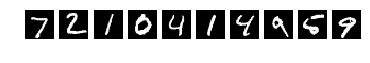

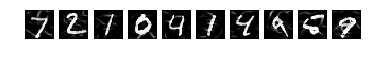

true labels: [7 2 1 0 4 1 4 9 5 9]
pred labels: [7 2 1 0 4 1 4 9 5 9]
adversarial target labels: [1, 8, 7, 9, 7, 3, 1, 6, 2, 0]
attacked labels: [1 8 7 9 7 3 1 6 2 0]


In [13]:

for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow((x_test[i] * 255).astype(int), cmap='Greys_r')
    plt.axis('off')
plt.show()

for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow((list_new_imgs[i] * 255).astype(int), cmap='Greys_r')
    plt.axis('off')
plt.show()

model = create_network()
model.load_weights('best_weights.hdf5')
attacked_labels = model.predict(np.stack(list_new_imgs)).argmax(axis=1)

print('true labels: %s' % (y_test[0:10],))
print('pred labels: %s' % (pred_labels[0:10],))
print('adversarial target labels: %s' % (targets[0:10],))
print('attacked labels: %s' % (attacked_labels[0:10],))
